[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/Toxic_comments/blob/main/toxic_comments.ipynb)

Реализация классификатора токсичных комментариев на базе датасета
https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments  

Дубликат файла: https://cloud.mail.ru/public/Z4L3/vB8GcgTtK

In [1]:
import time

import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer#, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from sklearn.metrics import accuracy_score

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [16]:
# архитектура модели + 
# загрузчик данных +
# формирование батча +
# инициализировать модель +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [29]:
MAX_LEN_SENTENCE = 512
BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


## Загрузка данных

In [3]:
dataset = pd.read_csv('labeled.csv')
dataset

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\r\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Датасет представляет собой таблицу размеченных комментариев (является ли toxic-abuse)

In [4]:
sentences = dataset['comment'].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] if label == 1 else [0] for label in dataset['toxic'].values]

assert len(sentences) == len(labels)

print(sentences[24])

[CLS] Да какая агрессия. Тебя ткнули в твое же дерьмо. Обтекай. Это я без отрицательных эмоций. Просто факт.
 [SEP]


Разделение датасета на обучающую, валидационную и тестовую выборки

In [26]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.15)
valid_sentences, test_sentences, valid_gt, test_gt = train_test_split(test_sentences, test_gt, test_size=0.5)

print(f"Размер обучающей выборки:     {len(train_gt)}")
print(f"Размер валидационной выборки: {len(valid_gt)}")
print(f"Размер тестовой выборки:      {len(test_gt)}")

Размер обучающей выборки:     12250
Размер валидационной выборки: 1081
Размер тестовой выборки:      1081


Токенизация текста

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  # bert-base модель BERT с 12 s-attention модулями
                                                                                    # uncased - все слова в нижнем регистре
train_tokenized = [tokenizer.tokenize(sent) for sent in train_sentences]
valid_tokenized = [tokenizer.tokenize(sent) for sent in valid_sentences]
test_tokenized =  [tokenizer.tokenize(sent) for sent in test_sentences]

print (train_tokenized[0])

['[CLS]', 'я', 'в', 'м', '##е', '##т', '##р', '##о', 'н', '##е', 'и', '##г', '##р', '##а', '##л', 'и', 'д', '##а', '##ж', '##е', 'н', '##е', 'д', '##о', '##ч', '##и', '##т', '##а', '##л', 'к', '##н', '##и', '##г', '##у', ',', 'н', '##о', 'м', '##н', '##е', 'к', '##а', '##ж', '##е', '##т', '##с', '##я', 'п', '##р', '##о', '##ж', '##е', '##к', '##т', '##о', '##р', '##ы', 'с', 'м', '##о', '##н', '##с', '##т', '##р', '##а', '##м', '##и', 'с', '##п', '##р', '##а', '##в', '##и', '##л', '##и', '##с', '##ь', 'б', '##ы', 'л', '##у', '##ч', '##ш', '##е', 'о', '##к', '##о', '##н', '##н', '##о', '##г', '##о', 'с', '##в', '##е', '##т', '##а', ',', 'з', '##а', '##о', '##д', '##н', '##о', 'с', '##л', '##е', '##п', '##я', 'и', '##х', '.', 'в', '##о', '##о', '##б', '##щ', '##е', 'л', '##о', '##г', '##и', '##ч', '##н', '##о', 'и', '##м', '##е', '##т', '##ь', 'б', '##у', '##н', '##к', '##е', '##р', '##у', 'р', '##а', '##з', '##р', '##а', '##б', '##а', '##т', '##ы', '##в', '##а', '##е', '##м', '##ы', '##е

Формирование inputs (id токенов, маски, метки классов)

In [38]:
def make_inputs_and_masks(tokenized_texts):
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    input_ids = pad_sequences(input_ids,
                              maxlen=MAX_LEN_SENTENCE,
                              dtype="long",
                              truncating="post",
                              padding="post"
                              )
    input_ids = torch.tensor(input_ids)

    attention_masks = torch.tensor([[float(i>0) for i in seq] for seq in input_ids])

    return input_ids, attention_masks

In [39]:
train_inputs, train_masks =           make_inputs_and_masks(train_tokenized)
validation_inputs, validation_masks = make_inputs_and_masks(valid_tokenized)
test_inputs, test_masks =             make_inputs_and_masks(test_tokenized)

train_labels =      torch.tensor(train_gt)
validation_labels = torch.tensor(valid_gt)
test_labels =       torch.tensor(test_gt)

train_labels

Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1078 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

## Формирование батча

In [45]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data,
                              sampler=RandomSampler(train_data),
                              batch_size=BATCH_SIZE
                              )

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data,
                                   sampler=SequentialSampler(validation_data),
                                   batch_size=BATCH_SIZE
                                   )

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data,
                             sampler=SequentialSampler(test_data),
                             batch_size=BATCH_SIZE
                             )

## Инициализация модели и задание оптимизатора

In [55]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
try:
    model.cuda()
except:
    pass

In [56]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)    # рекомендуется 5e-5 / 3e-5 / 2e-5

## Обучение модели

In [48]:
def train(model, dataloader, optimizer, train_loss_history=None, valid_loss_history=None,
          train_accuracy_history=None, valid_accuracy_history=None):

    # Переводим модель в training mode
    model.train()
    
    # Будем сохранять loss во время обучения и рисовать график в режиме реального времени
    epoch_loss = 0
    loss_history = []

    train_preds, train_labels = [], []
    
    for step, batch in enumerate(dataloader):
        
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()
        
        # Forward pass
        loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss_history.append(loss.item())  
        
        # Backward pass
        loss.backward()
        
        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()

        # Обновляем loss
        epoch_loss += loss.item()
        
        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        train_preds.extend(batch_preds)
        train_labels.extend(batch_labels)

        # Рисуем график
        
        if (step+1)%10==0:
            
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
            
            clear_output(True)           
            ax[0].plot(loss_history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title(f'Train loss current epoch')
            if train_loss_history is not None:
                ax[1].plot(train_loss_history, label='Train')
            if valid_loss_history is not None:
                ax[1].plot(valid_loss_history, label='Valid')
            if (train_loss_history is not None) or (valid_loss_history is not None):
                ax[1].set_xlabel('Epoch')
                ax[1].set_title('General loss history')
                ax[1].legend()
            if train_accuracy_history is not None:
                ax[2].plot(train_accuracy_history, label='Train')
            if valid_accuracy_history is not None:
                ax[2].plot(valid_accuracy_history, label='Valid')   
            if (train_accuracy_history is not None) or (valid_accuracy_history is not None):        
                ax[2].set_xlabel('Epoch')
                ax[2].set_title('General accuracy history')
                ax[2].legend()
            plt.show()
        
    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(train_labels, train_preds) * 100

    return loss, accuracy

#train_history = []
#valid_history = []
#train_accuracy_history = []
#valid_accuracy_history = []

#train(model, train_dataloader, optimizer, train_history, valid_history, train_accuracy_history, valid_accuracy_history)

In [49]:
def evaluate(model, dataloader):
    
    # Переводим модель в evaluation mode
    model.eval()
    
    epoch_loss = 0
    
    valid_preds, valid_labels = [], []
    
    for batch in dataloader:
        
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
            
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch            

        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        with torch.no_grad():
            loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            
        epoch_loss += loss.item()

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
            
        batch_preds = np.argmax(logits, axis=1)
        batch_labels = np.concatenate(label_ids)     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    loss = epoch_loss / len(dataloader)
    accuracy = accuracy_score(valid_labels, valid_preds) * 100

    return loss, accuracy

#evaluate(model, validation_dataloader)

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
def train_eval_loop(model, train_iterator, valid_iterator, model_name, N_EPOCHS=10):

    train_loss_history = []
    valid_loss_history = []
    
    train_accuracy_history = []
    valid_accuracy_history = []
    
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        try:
        
            start_time = time.time()
            
            train_loss, train_accuracy = train(model, train_iterator, optimizer, train_loss_history, valid_loss_history,
                               train_accuracy_history, valid_accuracy_history)
            valid_loss, valid_accuracy = evaluate(model, valid_iterator)

            end_time = time.time()
            
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                print('Новый минимальный лосс на валидации:', best_valid_loss, 'на', epoch, 'эпохе')
                torch.save(model.state_dict(), model_name)

            train_loss_history.append(train_loss)
            valid_loss_history.append(valid_loss)

            train_accuracy_history.append(train_accuracy)
            valid_accuracy_history.append(valid_accuracy)

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}')
            print(f'\t Val. Loss: {valid_loss:.3f} | Val. Accuracy:  {valid_accuracy:.2f}')
        
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break

    return None

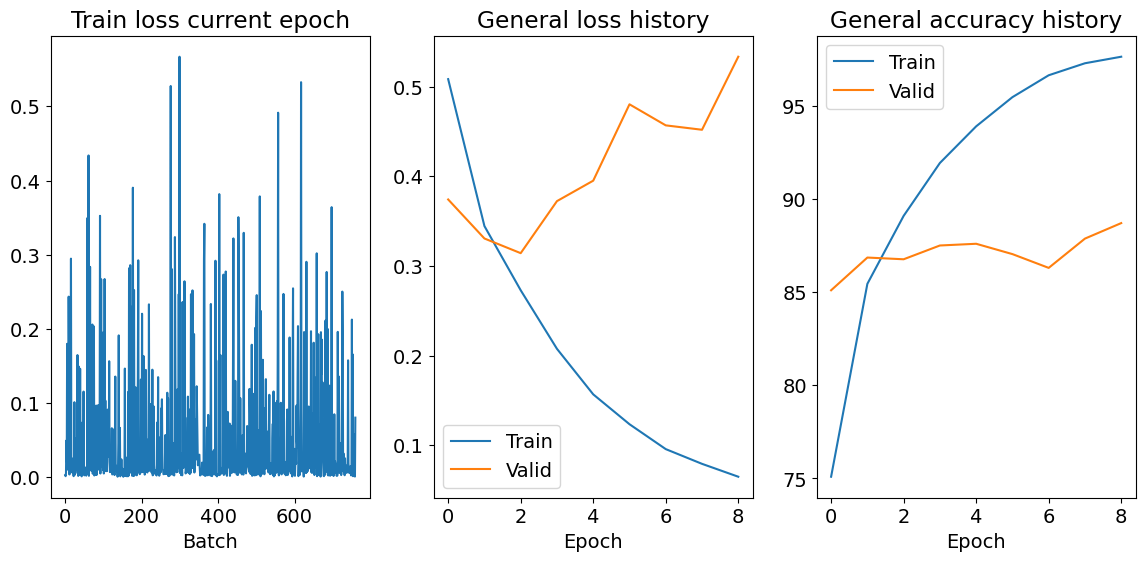

Epoch: 10 | Time: 5m 26s
	Train Loss: 0.054 | Train Accuracy: 98.13
	 Val. Loss: 0.586 | Val. Accuracy:  88.44


In [57]:
# new 2
MODEL_NAME = 'BERT_CLS_TOXIC.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=10)

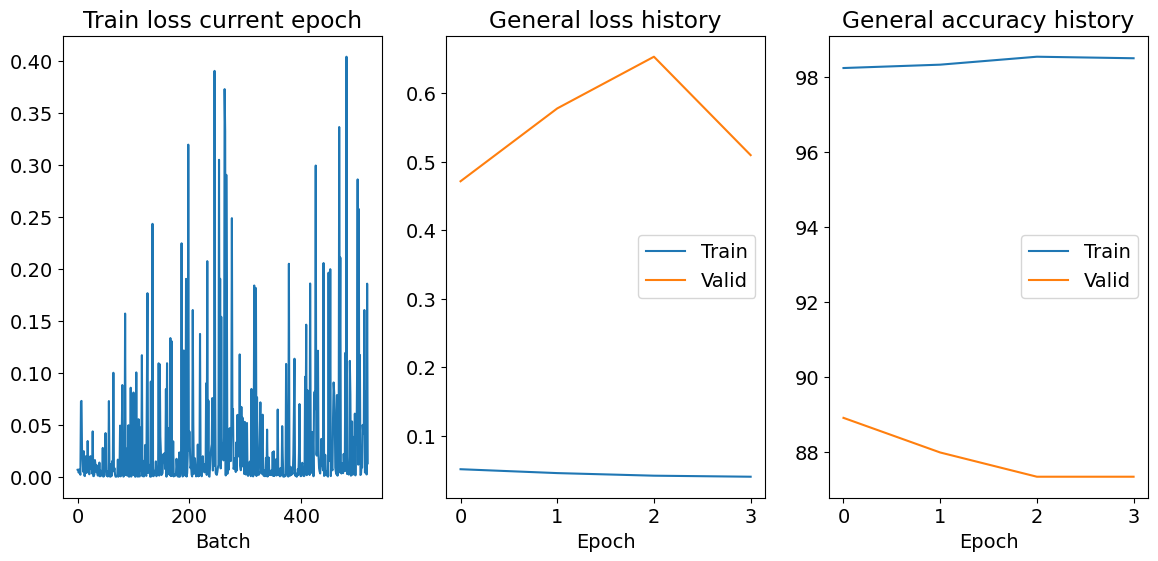

Досрочно остановлено пользователем


In [69]:
# добавим еще 5 эпох обучения
MODEL_NAME = 'BERT_CLS_TOXIC.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=5)

In [58]:
torch.save(model.state_dict(), 'BERT_CLS_TOXIC_10.pt')

In [65]:
model.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

## Оценка качества на отложенной выборке

In [66]:
_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке составил: 86.86%


In [67]:
model.load_state_dict(torch.load('BERT_CLS_TOXIC_10.pt'))

<All keys matched successfully>

In [68]:
#Мы загружаем наши «лучшие» параметры и добиваемся большей точности при тестировании, чем достигали все предыдущие модели.
#model.load_state_dict(torch.load(MODEL_NAME))

_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке составил: 88.81%


In [102]:
pos_texts = pd.read_csv('datasets/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('datasets/negative.csv', encoding='utf8', sep=';', header=None)

pretrain_sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])
pretrain_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in pretrain_sentences]

pretrain_gt = [[0] for _ in range(pos_texts.shape[0])] + [[1] for _ in range(neg_texts.shape[0])]

assert len(pretrain_sentences) == len(pretrain_gt) == pos_texts.shape[0] + neg_texts.shape[0]
print(pretrain_sentences[15])

[CLS] @Jyliaalex смотри там случайно в аспирантуру не попади, наука никого до добра не доводила) [SEP]


In [103]:
pretrain_tokenized = [tokenizer.tokenize(sent) for sent in pretrain_sentences]
pretrain_inputs, pretrain_masks = make_inputs_and_masks(pretrain_tokenized)
pretrain_labels = torch.tensor(pretrain_gt)
pretrain_labels

tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]])

In [104]:
pretrain_data = TensorDataset(pretrain_inputs, pretrain_masks, pretrain_labels)
pretrain_dataloader = DataLoader(pretrain_data,
                                 sampler=RandomSampler(pretrain_data),
                                 batch_size=BATCH_SIZE
                                 )

In [105]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
try:
    model.cuda()
except:
    pass

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)    # рекомендуется 5e-5 / 3e-5 / 2e-5

In [106]:
_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке до файнтюнинга: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке до файнтюнинга: 35.52%


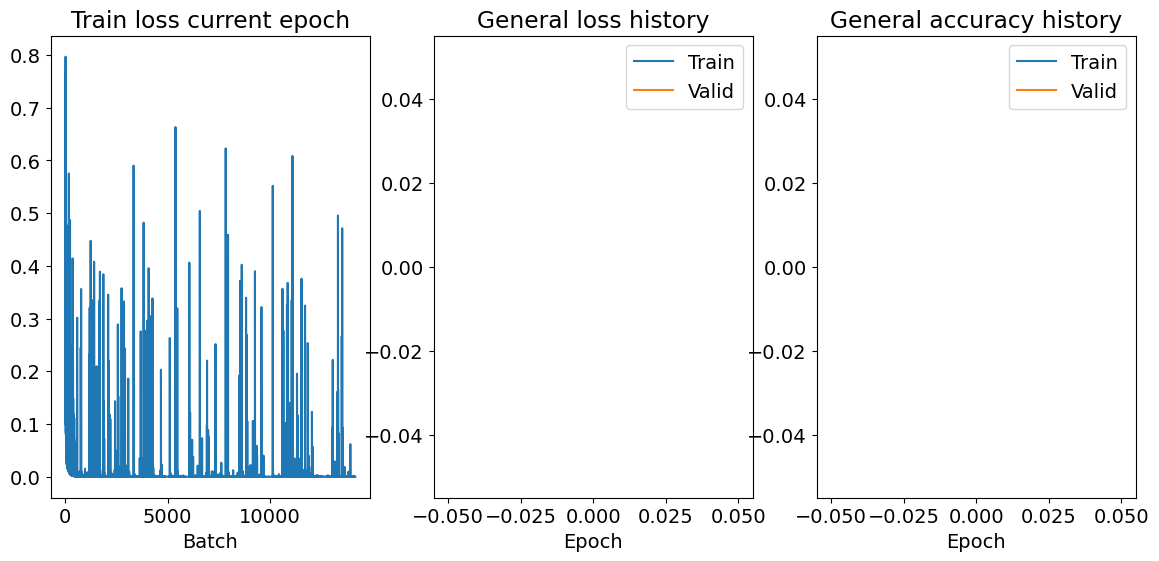

Новый минимальный лосс на валидации: 1.9915357889497982 на 0 эпохе
Epoch: 01 | Time: 101m 26s
	Train Loss: 0.005 | Train Accuracy: 99.87
	 Val. Loss: 1.992 | Val. Accuracy:  59.11


In [107]:
MODEL_NAME = 'BERT_CLS_PRETRAIN.pt'

train_eval_loop(model, pretrain_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=1)

In [108]:
_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке после предварительного обучения: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке после предварительного обучения: 59.39%


In [110]:
model.load_state_dict(torch.load('BERT_CLS_PRETRAIN.pt'))

<All keys matched successfully>

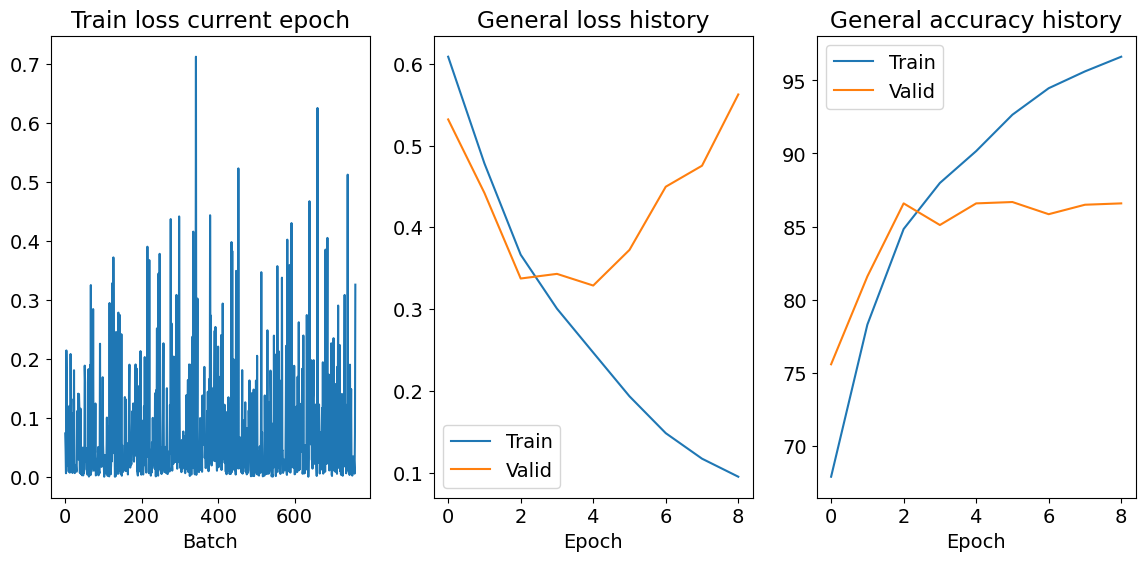

Epoch: 10 | Time: 5m 27s
	Train Loss: 0.077 | Train Accuracy: 97.36
	 Val. Loss: 0.521 | Val. Accuracy:  87.14


In [111]:
MODEL_NAME = 'BERT_CLS_TOXIC_AFT_PRETRAIN.pt'

train_eval_loop(model, train_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=10)

In [112]:
_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке после дообучения: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке после дообучения: 87.42%


## Обучение на обоих датасетах совместно

In [130]:
train_ext_sentences = pretrain_sentences + train_sentences
train_ext_gt = pretrain_gt + train_gt

In [131]:
train_ext_tokenized = [tokenizer.tokenize(sent) for sent in train_ext_sentences]
train_ext_inputs, train_ext_masks = make_inputs_and_masks(train_ext_tokenized)
train_ext_labels = torch.tensor(train_ext_gt)
train_ext_labels

Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1578 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (832 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1078 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [132]:
train_ext_data = TensorDataset(train_ext_inputs, train_ext_masks, train_ext_labels)
train_ext_dataloader = DataLoader(train_ext_data,
                                 sampler=RandomSampler(train_ext_data),
                                 batch_size=BATCH_SIZE
                                 )

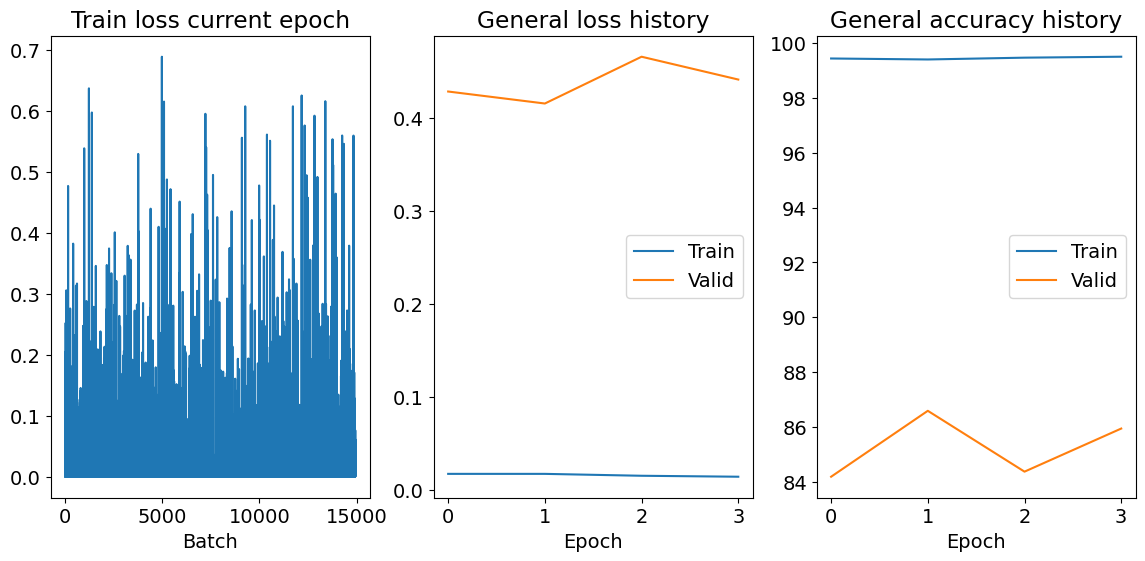

Epoch: 05 | Time: 106m 31s
	Train Loss: 0.013 | Train Accuracy: 99.56
	 Val. Loss: 0.430 | Val. Accuracy:  85.48


In [133]:
MODEL_NAME = 'BERT_CLS_TOXIC_EXP.pt'

train_eval_loop(model, train_ext_dataloader, validation_dataloader, model_name=MODEL_NAME, N_EPOCHS=5)

In [134]:
#Мы загружаем наши «лучшие» параметры и добиваемся большей точности при тестировании, чем достигали все предыдущие модели.
model.load_state_dict(torch.load('BERT_CLS_TOXIC_EXP.pt'))

_, test_accuracy = evaluate(model, test_dataloader)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(test_accuracy))

Процент правильных предсказаний на отложенной выборке составил: 86.77%


In [ ]:
tfidf

# логистическая регрессия
0.8488225399495374
0.7233551365909966

# svc
0.8591253153910849
0.7486871717929482

# LinearSVC
0.8708999158957107
0.7869535045107565

# градиентный бустинг
0.7714465937762826
0.4965261695229273

# случайный лес
0.8269554247266611
0.713340299547196

In [379]:
phrase = "Хорошая погода"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Хорошая погода

Классификация с помощью логистической регрессии:
The comment isn't toxic

Классификация с помощью SVC:
The comment isn't toxic

Классификация с помощью LinearSVC:
The comment isn't toxic

Классификация с помощью градиентного бустинга:
The comment isn't toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [380]:
phrase = "Меня окружают одни идиоты"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Меня окружают одни идиоты

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment is toxic


In [381]:
phrase = "Тупоголовые дебилы"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Тупоголовые дебилы

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment is toxic

Классификация с помощью стэкинга:
The comment is toxic


In [382]:
phrase = "всех чертей расстрелять"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: всех чертей расстрелять

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [383]:
phrase = "пес по кличке балбес"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: пес по кличке балбес

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment isn't toxic


In [384]:
phrase = "воинствующий идиот"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: воинствующий идиот

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment isn't toxic

Классификация с помощью стэкинга:
The comment is toxic


In [386]:
phrase = "Иди свиней паси"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии:")
print(predict_logreg(phrase))
print("\nКлассификация с помощью SVC:")
print(predict_svc(phrase))
print("\nКлассификация с помощью LinearSVC:")
print(predict_linearSVC(phrase))
print("\nКлассификация с помощью градиентного бустинга:")
print(predict_RandForest(phrase))
print("\nКлассификация с помощью случайного леса:")
print(predict_GradBst(phrase))
print("\nКлассификация с помощью стэкинга:")
print(predict_Stacking_models(phrase))

Фраза: Иди свиней паси

Классификация с помощью логистической регрессии:
The comment is toxic

Классификация с помощью SVC:
The comment is toxic

Классификация с помощью LinearSVC:
The comment is toxic

Классификация с помощью градиентного бустинга:
The comment is toxic

Классификация с помощью случайного леса:
The comment is toxic

Классификация с помощью стэкинга:
The comment is toxic


In [354]:
phrase = "Винтажный газогенератор"
print(f"Фраза: {phrase}")
print("\nКлассификация с помощью логистической регрессии: ")
predict_logreg(phrase)
print("\nКлассификация с помощью градиентного бустинга: ")
predict_RandForest(phrase)
print("\nКлассификация с помощью случайного леса: ")
predict_GradBst(phrase)
print("\nКлассификация с помощью стэкинга: ")
predict_Stacking_models(phrase)

Фраза: Винтажный газогенератор

Классификация с помощью логистической регрессии: 
The comment isn't toxic [0.]

Классификация с помощью градиентного бустинга: 
The comment is toxic

Классификация с помощью случайного леса: 
The comment isn't toxic

Классификация с помощью стэкинга: 
The comment isn't toxic
